In [199]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
from numpy import concatenate

# fix random seed for reproducibility
numpy.random.seed(7)
COUNTRY = "Netherlands"
X = "stringency_index"
Z = "Confirmed"

In [200]:
df = pd.read_csv("../input/covid19dh.csv")
df = df[(df["Country/Region"] == COUNTRY) & (df['Province/State'].isnull())]
df["ObservationDate"] = pd.to_datetime(df["ObservationDate"]) 

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [204]:
columns = ["stringency_index", "Deaths", "Confirmed"]
df = df[columns]

KeyError: "['Deaths'] not in index"

In [206]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = df.copy()
# dataset = dataset.set_index("ObservationDate")
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.tail())

     var1(t-1)  var2(t-1)   var1(t)   var2(t)
444   0.910084   0.989744  0.910084  0.992308
445   0.910084   0.992308  0.910084  0.994872
446   0.910084   0.994872  0.910084  0.997436
447   0.910084   0.997436  0.910084  1.000000
448   0.910084   1.000000  0.910084  1.000000


In [241]:
# split into train and test sets
n_train_hours = int(len(values) / 1.1)
values = reframed.values
# n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(407, 1, 3) (407,) (41, 1, 3) (41,)


Epoch 1/200
12/12 - 0s - loss: 0.3697 - val_loss: 0.8401
Epoch 2/200
12/12 - 0s - loss: 0.2930 - val_loss: 0.7168
Epoch 3/200
12/12 - 0s - loss: 0.2375 - val_loss: 0.6078
Epoch 4/200
12/12 - 0s - loss: 0.2040 - val_loss: 0.5115
Epoch 5/200
12/12 - 0s - loss: 0.1814 - val_loss: 0.4255
Epoch 6/200
12/12 - 0s - loss: 0.1643 - val_loss: 0.3447
Epoch 7/200
12/12 - 0s - loss: 0.1475 - val_loss: 0.2656
Epoch 8/200
12/12 - 0s - loss: 0.1354 - val_loss: 0.1956
Epoch 9/200
12/12 - 0s - loss: 0.1334 - val_loss: 0.1548
Epoch 10/200
12/12 - 0s - loss: 0.1326 - val_loss: 0.1408
Epoch 11/200
12/12 - 0s - loss: 0.1274 - val_loss: 0.1369
Epoch 12/200
12/12 - 0s - loss: 0.1200 - val_loss: 0.1294
Epoch 13/200
12/12 - 0s - loss: 0.1130 - val_loss: 0.1161
Epoch 14/200
12/12 - 0s - loss: 0.1067 - val_loss: 0.1005
Epoch 15/200
12/12 - 0s - loss: 0.1009 - val_loss: 0.0878
Epoch 16/200
12/12 - 0s - loss: 0.0948 - val_loss: 0.0787
Epoch 17/200
12/12 - 0s - loss: 0.0883 - val_loss: 0.0704
Epoch 18/200
12/12 - 0s

Epoch 142/200
12/12 - 0s - loss: 0.0071 - val_loss: 0.0054
Epoch 143/200
12/12 - 0s - loss: 0.0127 - val_loss: 0.0029
Epoch 144/200
12/12 - 0s - loss: 0.0179 - val_loss: 0.0104
Epoch 145/200
12/12 - 0s - loss: 0.0081 - val_loss: 0.0071
Epoch 146/200
12/12 - 0s - loss: 0.0079 - val_loss: 0.0060
Epoch 147/200
12/12 - 0s - loss: 0.0111 - val_loss: 0.0151
Epoch 148/200
12/12 - 0s - loss: 0.0172 - val_loss: 0.0131
Epoch 149/200
12/12 - 0s - loss: 0.0053 - val_loss: 4.6959e-04
Epoch 150/200
12/12 - 0s - loss: 0.0076 - val_loss: 0.0072
Epoch 151/200
12/12 - 0s - loss: 0.0105 - val_loss: 0.0116
Epoch 152/200
12/12 - 0s - loss: 0.0048 - val_loss: 0.0060
Epoch 153/200
12/12 - 0s - loss: 0.0045 - val_loss: 0.0041
Epoch 154/200
12/12 - 0s - loss: 0.0108 - val_loss: 5.6545e-04
Epoch 155/200
12/12 - 0s - loss: 0.0102 - val_loss: 0.0053
Epoch 156/200
12/12 - 0s - loss: 0.0097 - val_loss: 0.0026
Epoch 157/200
12/12 - 0s - loss: 0.0043 - val_loss: 0.0019
Epoch 158/200
12/12 - 0s - loss: 0.0100 - val_lo

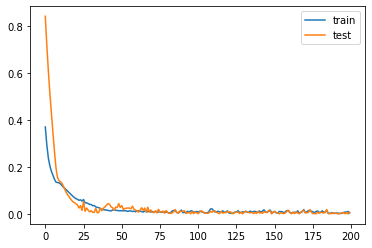

In [243]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [257]:
import plotly.graph_objects as go

fig = px.line(x=history.history['loss'], title='Train')

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'],
                    mode='lines', name="Train",))
fig.add_trace(go.Scatter(y=history.history['val_loss'],
                    mode='lines', name="Validation",))
fig.update_layout(
    template="plotly_white",
    width=500,
    height=400
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.81
), title="LSTM model loss", font_family="Arial",
                 xaxis_title="Epoch", yaxis_title="Loss")

fig.show()

In [238]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

scaler2 = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler2.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler2.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.007


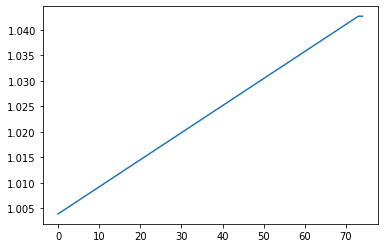

In [239]:
plt.plot(inv_y)
plt.show()

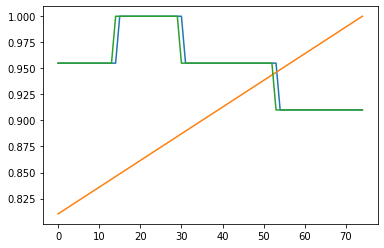

In [240]:
plt.plot(test_X)

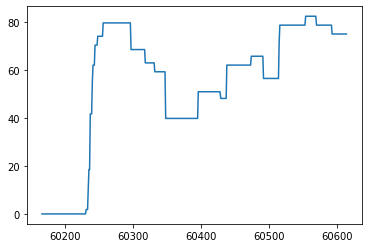

In [229]:
plt.plot(df["stringency_index"])